#
http://enu.kz/repository/2010/AIAA-2010-3412.pdf

In [1]:
import os
import glob
import LatLon 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5)

# plot
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
sns.set_style("whitegrid")
from pysurvey.plot import setup, legend, icolorbar, density, minmax

# date
from dateutil import parser
from matplotlib.dates import date2num

# database
import dataset
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

import sompy as SOM

In [2]:
before = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_before.csv')
after = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_after.csv')
during = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_during.csv')
clean = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_clean_2.csv')


In [3]:
during

,flight,date,time,alt,lat,lon,flightnum,datenum,hour,weekday,normtime,heading_deg,distance,heading,x,y
1204068,A03510,2016/01/23,02:24:24.331,43000,39.70312,-77.79019,470,8.000032,0.000757,1,0.486940,292.706645,108.467407,-1.174491,-100.359872,-41.146986
1204069,A03510,2016/01/23,02:24:24.911,43000,39.70249,-77.79211,470,8.000038,0.000919,1,0.486940,292.639920,108.594032,-1.175655,-100.428990,-41.312005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271894,C0331E,2016/01/25,01:17:51.032,34975,39.02911,-78.22713,2947,9.953813,22.891508,2,0.605861,256.874318,142.582569,-1.799883,-75.291829,-121.082325
1271895,C0331E,2016/01/25,01:17:59.707,35000,39.04485,-78.22906,2947,9.953913,22.893918,2,0.605867,257.572947,142.328326,-1.787689,-76.625721,-119.941032


In [4]:
from sklearn import manifold, datasets, cluster

n_neighbors = 5
n_components = 2
n_points=10000

In [242]:
input_tags = ['lat', 'lon', 'alt', 'hour', 'flightnum']

def make_data(cat):
    np.random.seed(0)
    ii = np.random.choice(before.index, n_points)
    X = np.zeros( (n_points, len(input_tags)) )
    for i,tag in enumerate(input_tags):
        tmp = before[tag][ii]
        X[:, i] = (tmp-tmp.mean()) / tmp.std()
    color = np.array(before['flightnum'][ii])
    return X, color
X, YModel = make_data(during)
print X.shape

(10000, 5)


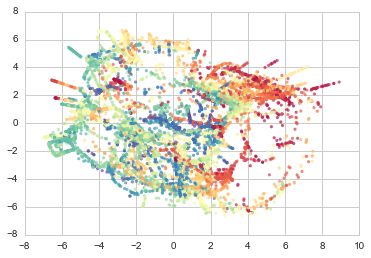

In [248]:
isomap = manifold.Isomap(n_neighbors, n_components)
Y = isomap.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

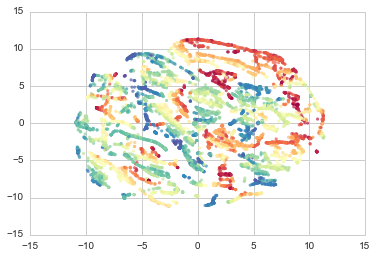

In [249]:
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

In [ ]:
se = manifold.SpectralEmbedding(n_components=n_components, affinity='rbf', n_neighbors=n_neighbors, random_state=0)
Y = se.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=color, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

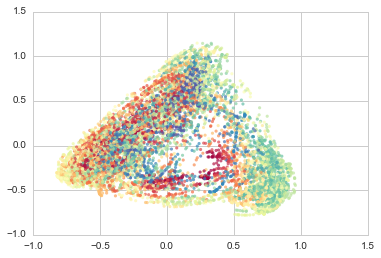

In [252]:
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

In [ ]:
mds = manifold.MDS(n_components, max_iter=100, n_init=1, random_state=0)
Y = mds.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=color, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

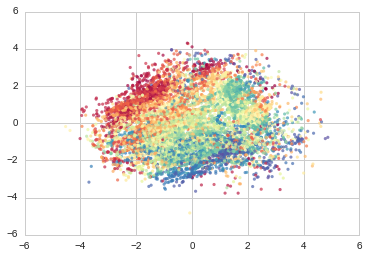

In [254]:
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

# Clustering

In [261]:
colors = np.array([x for x in 'bgrcmybgrcmybgrcmybgrcmy'])
colors = np.hstack([colors] * 40)

def run_clustering(model, **kwargs):
    alg = model(**kwargs)
    alg.fit(X)
    if hasattr(alg, 'labels_'):
        y_pred = alg.labels_.astype(np.int)
    else:
        y_pred = alg.predict(X)
    return y_pred

def plot_clustering(y_pred):
    pylab.figure(figsize=(12,6))
    pylab.subplot(121)
    pylab.title('From Flight Numbers')
    plt.scatter(X[:, 0], X[:, 1], c=YModel, s=10, lw=0, cmap=pylab.cm.jet)
    pylab.subplot(122)
    pylab.title('From Clusters')
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=10, lw=0, cmap=pylab.cm.jet)

(0, 77) 0.911446051951 78 685


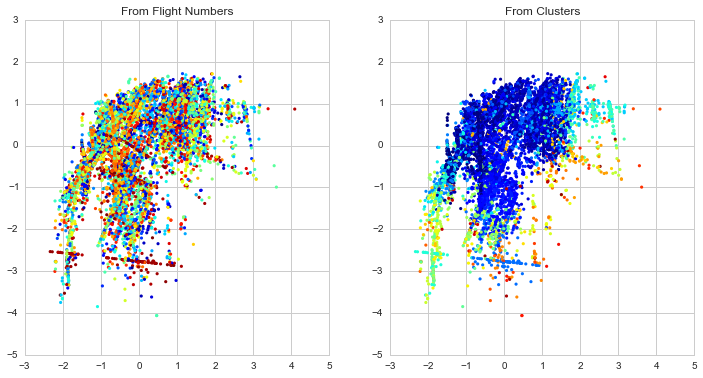

In [262]:
bandwidth = cluster.estimate_bandwidth(X, quantile=0.009)
y_pred = run_clustering(cluster.MeanShift, bandwidth=bandwidth, bin_seeding=True)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

(-1, 425) 0.911446051951 427 685


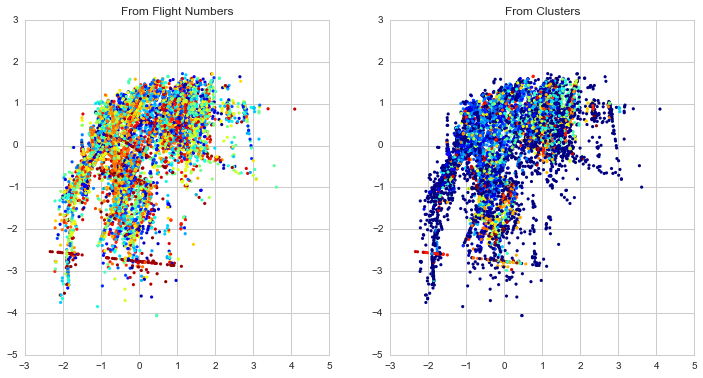

In [263]:
y_pred = run_clustering(cluster.DBSCAN, eps=0.3)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

In [264]:
from sklearn.neighbors import kneighbors_graph

(0, 684) 0.911446051951 685 685


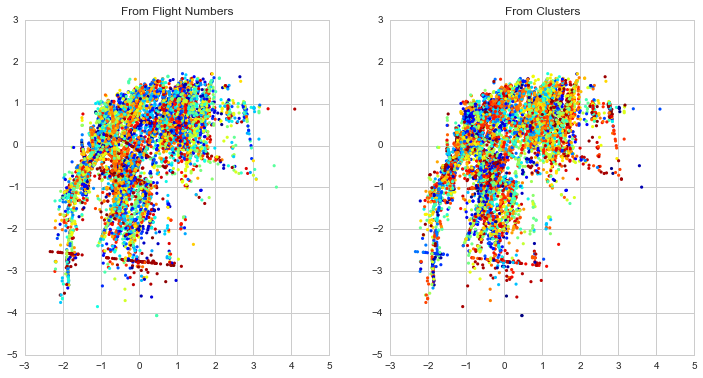

In [265]:
n_clusters = len(np.unique(Ymodel))
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)
y_pred = run_clustering(cluster.AgglomerativeClustering, 
                        n_clusters=n_clusters, linkage='ward',
                        connectivity=connectivity)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14072d210>]], dtype=object)

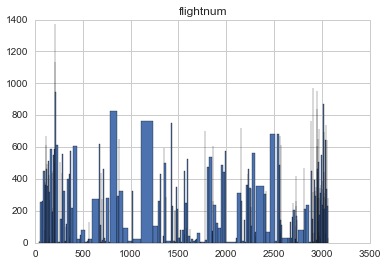

In [319]:
during.hist('flightnum', bins=np.unique(during['flightnum'])-0.5, )

In [5]:
import geoplotlib

In [6]:
# tmp = during.groupby('flightnum', as_index=True).count().sort('x')
tmp = during.groupby(['weekday', 'flightnum'], as_index=True).count().sort('x')
index = tmp.index[-2]
flight = during[during['flightnum'] == index[1]]
# flight.plot('lon', 'lat', 'scatter')
print index, len(flight)

geoplotlib.tiles_provider('darkmatter')
geoplotlib.dot(flight)
bbox = geoplotlib.utils.BoundingBox(40.5,-78.0,38.5,-76)
geoplotlib.set_bbox(bbox)
geoplotlib.inline(800)

(2, 2948) 955


/Users/ajmendez/.local/canopy/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [8]:
dtime = lambda x: (x - x.shift(1))
tmp = np.array((flight['datenum'] - flight['datenum'].shift()).fillna(0))*24

In [7]:
clean.loc[:, 'flightindex'] = 0

In [12]:
clean

,flight,date,time,alt,lat,lon,flightnum,datenum,hour,weekday,normtime,heading_deg,distance,heading,x,y,px,py,flightindex
0,AA9249,2016/01/15,02:24:21.604,8625,39.12570,-77.53583,2115,0.000000,0.000000,0,0.000000e+00,254.091033,82.037152,-1.848460,-39.886351,-71.688028,206.711111,99.627886,0
1,AA9249,2016/01/15,02:24:22.969,8675,39.12730,-77.53491,2115,0.000016,0.000379,0,9.616173e-07,254.194387,81.910595,-1.846656,-39.953869,-71.505481,206.711111,99.627886,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860972,4CA4B3,2016/01/29,01:30:01.789,33975,39.60013,-77.68341,320,13.962271,23.094496,6,8.498446e-01,288.421558,95.955069,-1.249279,-85.814791,-42.932469,193.711111,155.627886,0
1860973,4CA4B3,2016/01/29,01:30:03.232,33975,39.59938,-77.68634,320,13.962287,23.094897,6,8.498456e-01,288.328603,96.169497,-1.250902,-85.936638,-43.167886,192.711111,155.627886,0


In [18]:
for flightnum in np.unique(clean['flightnum']):
    isgood = (clean['flightnum'] == flightnum)
    tmp = clean[isgood]
    tmp2 = np.array((tmp['datenum'] - tmp['datenum'].shift()).fillna(0))*24
    clean.loc[isgood, 'flightindex'] = np.where(tmp2 > 0.5, 1,0)
    clean.loc[isgood, 'flightindex'] = np.cumsum(clean.loc[isgood, 'flightindex'])
#     break
# clean.loc[clean['flightindex'] > 0, 'flightindex'] = 1

# for name, group in clean.groupby('flightnum'):
#     tmp = np.array((group['datenum'] - group['datenum'].shift()).fillna(0))*24
#     clean.loc(clean['flightnum']==name, 'deltatime') = tmp
#     break


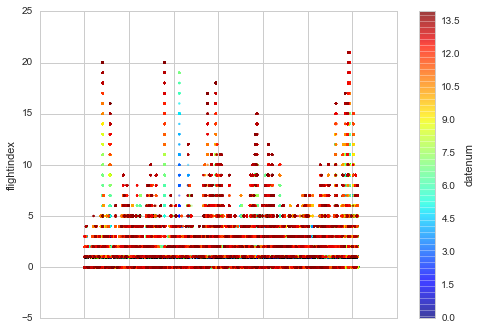

In [22]:
clean.plot('flightnum', 'flightindex', c='datenum', kind='scatter', 
           marker='.', alpha=0.5, lw=0, cmap=pylab.cm.jet)

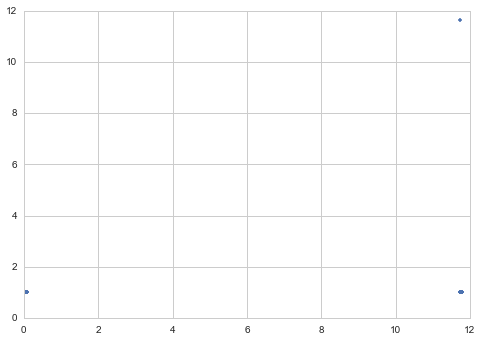

In [96]:
pylab.plot(np.cumsum(tmp2), clean.loc[isgood, 'flightindex'], '.')

In [84]:
flightnum, tmp2.shape, isgood.shape

(1, (241,), (1860239,))

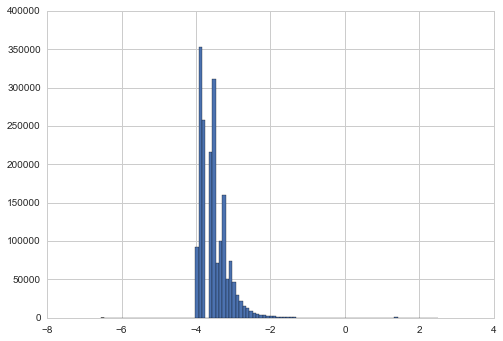

In [70]:
_ = pylab.hist(np.array(np.log10(clean.loc[clean['deltatime']>0, 'deltatime'])), 100)

In [44]:
group_names = np.unique(clean['flightnum'])
bins = [-1000, 0,0.5,1,1000]
pd.cut(clean['flightnum'], bins, include_lowest=True)

0                NaN
1                NaN
             ...    
1860972    (1, 1000]
1860973    (1, 1000]
Name: flightnum, dtype: category
Categories (4, object): [[-1000, 0] < (0, 0.5] < (0.5, 1] < (1, 1000]]